Reading the GeoTIFF as a plain image, not caring about the georeference for now

In [49]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None # Disable warnings for pillow DecompressionBombError

im = Image.open('popsub.tif')

Convert to numpy array

In [50]:
import numpy as np
raster = np.array(im)
raster.shape

(183, 326)

Let's take a subset of the 2D array to keep things manageable

In [51]:
raster = raster[0:150,0:150]
raster.shape

(150, 150)

Plot with matplotlib

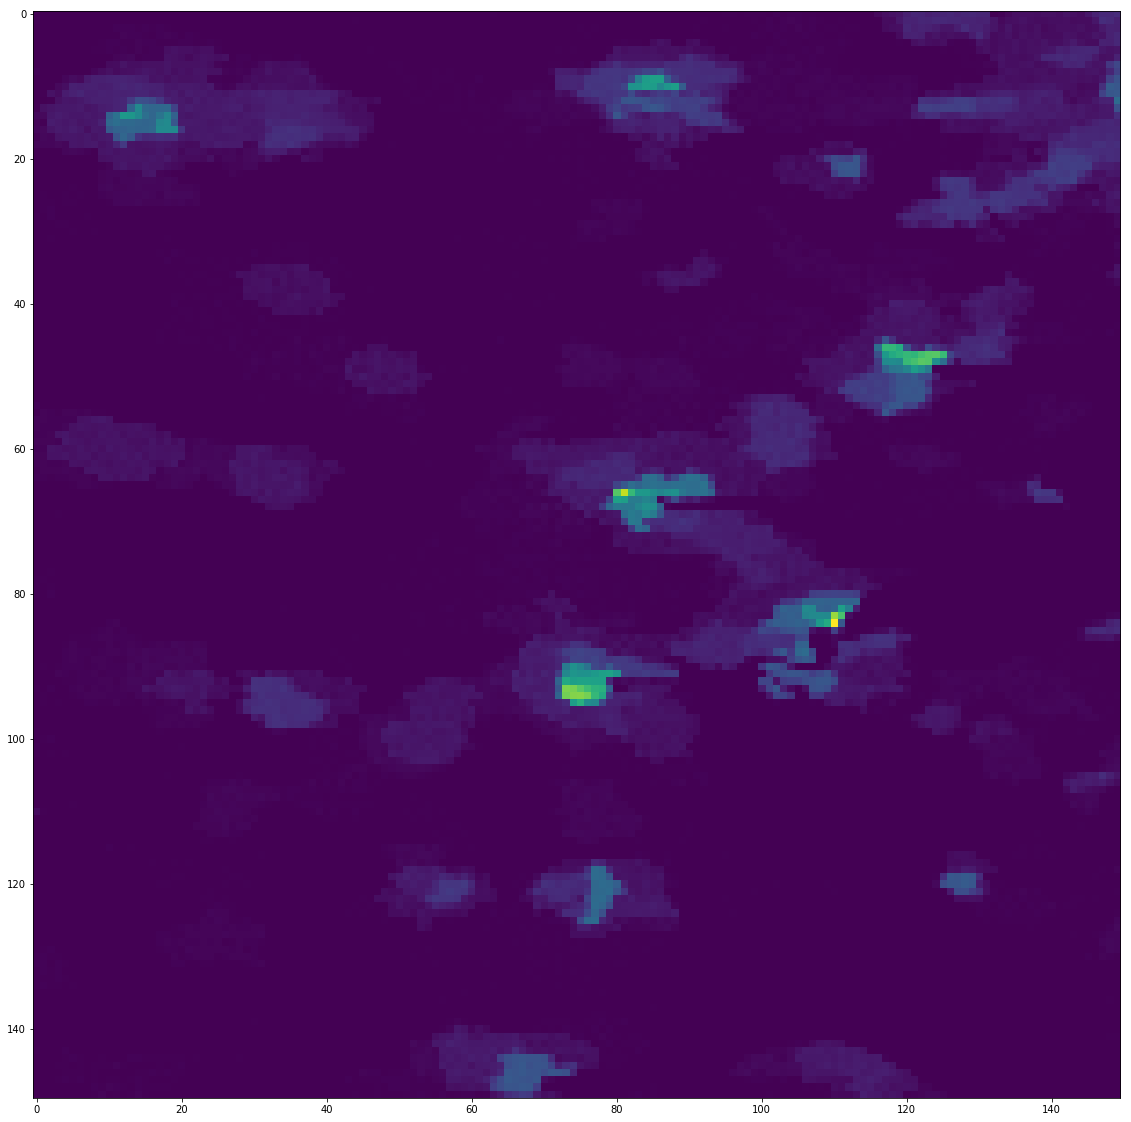

In [52]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# make the inline image outputs larger
mpl.rcParams['figure.figsize'] = (20,20)
plt.imshow(raster)

In [53]:
numpoints = np.sum(raster)
points = np.zeros((numpoints,2), dtype=int)
points

array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]])

In [54]:
%%timeit
point = 0
for r in range(0, raster.shape[0]):
    for c in range(0, raster.shape[1]):
        # create a n points for number n in the raster cell:
        for n in range(0, raster[r,c]):
            points[point,0] = r
            points[point,1] = c
            point = point + 1

275 ms ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
points

array([[  0,   0],
       [  0,   0],
       [  0,   0],
       ...,
       [149, 126],
       [149, 126],
       [149, 126]])

In [56]:
points.size

1620658

Next, we will randomly move each point around within its cell. We can also choose to keep the "edges" between the cells (set expansion to < 1.0) or allow the points to go outside the cells, which "softenes" the edges, giving the impression of a more smooth surface (set expansion to > 1.0)

In [57]:
expansion = 0.95

seed = np.random.rand(numpoints,2)
seed = seed * expansion

plot = points + seed

Plot:

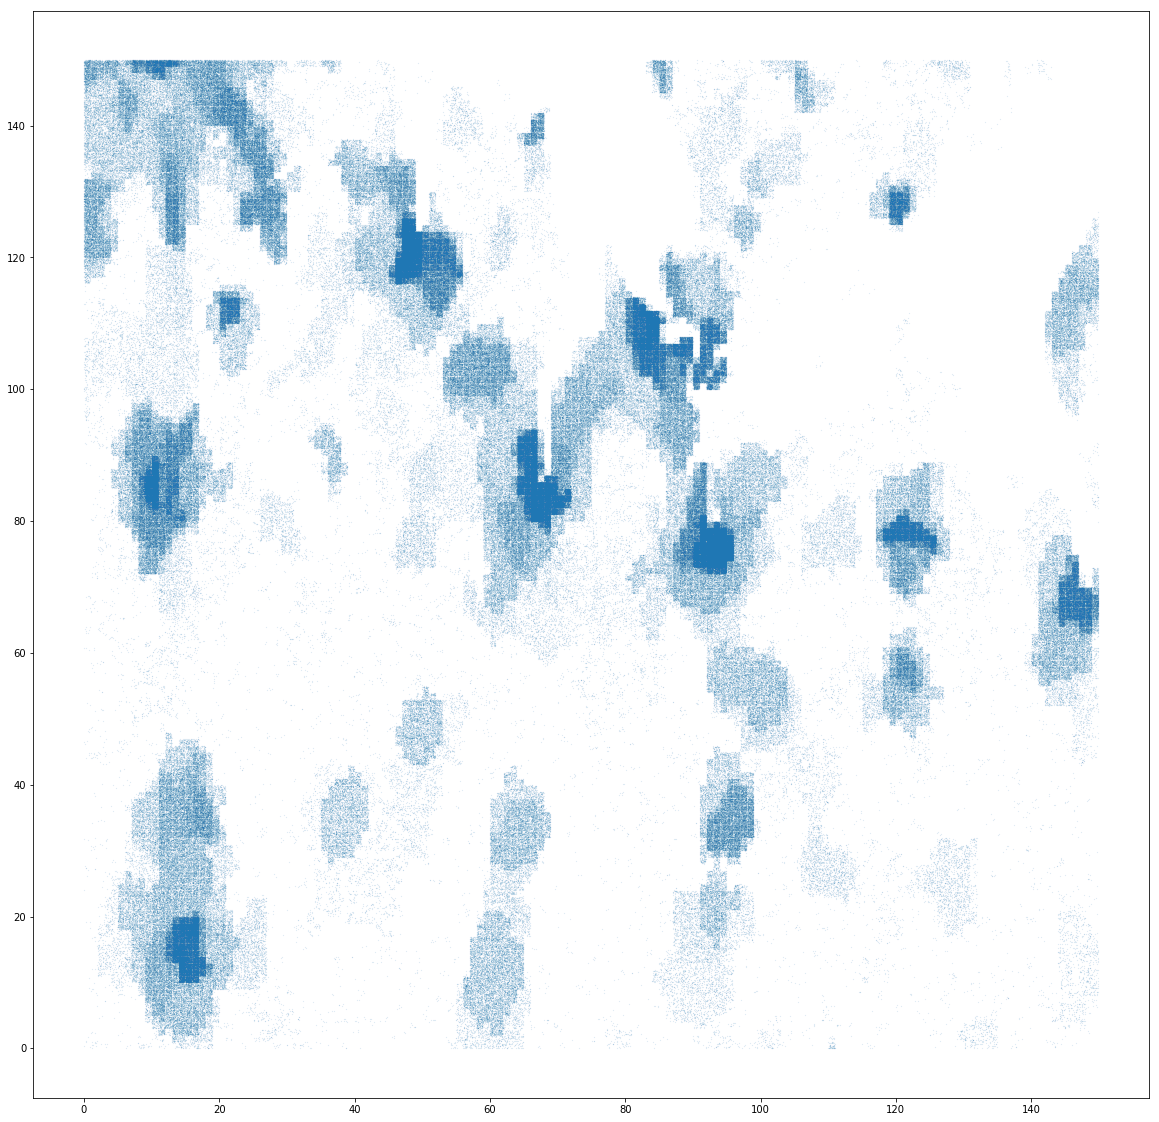

In [58]:
plt.scatter(plot[:,0], plot[:,1], s=0.01, alpha=0.5)
plt.show()